In [1]:
import torch
import numpy as np
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from skimage import io
from torchvision.transforms.functional import InterpolationMode as IMode
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import time
import torchvision.models as models
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Preparation

In [3]:
class DatasetSuperResolution(Dataset):

    def __init__(
            self,
            path_to_data: str,
            mode: str = 'train',
            image_size: int = 1080,
            upscale_factor: int = 4

    ):
        super(DatasetSuperResolution, self).__init__()

        self.files = [os.path.join(path_to_data, x) for x in os.listdir(path_to_data)]

        if mode == "train":
            self.hr_transforms = transforms.Compose([
                transforms.RandomCrop(image_size, pad_if_needed = True)
            ])
        else:
            self.hr_transforms = transforms.CenterCrop(image_size)

        self.lr_transforms = transforms.Resize(
            image_size // upscale_factor,
            interpolation = IMode.BICUBIC,
            antialias = True
        )

    def __getitem__(self, _index: int) -> [torch.Tensor, torch.Tensor]:
        image = io.imread(self.files[_index])
        image = transforms.ToTensor()(image)

        hr_image = self.hr_transforms(image)
        lr_image = self.lr_transforms(hr_image)

        return lr_image, hr_image

    def __len__(self) -> int:
        return len(self.files)


class DatasetNoiseReduction(Dataset):

    def __init__(
            self,
            path_to_data: str,
            mode: str = 'train',
            image_size: int = 1080,
            upscale_factor: int = 4

    ):
        super(DatasetNoiseReduction, self).__init__()

        self.files = [os.path.join(path_to_data, x) for x in os.listdir(path_to_data)]

        if mode == "train":
            self.hr_transforms = transforms.Compose([
                transforms.RandomCrop(image_size, pad_if_needed = True)
            ])
        else:
            self.hr_transforms = transforms.CenterCrop(image_size)

        self.lr_transforms = transforms.Compose([
        AddGaussianNoise(0., 0.1**0.5)]
        )

    def __getitem__(self, _index: int) -> [torch.Tensor, torch.Tensor]:
        image = io.imread(self.files[_index])
        image = transforms.ToTensor()(image)

        hr_image = self.hr_transforms(image)
        lr_image = self.lr_transforms(hr_image)

        return lr_image, hr_image

    def __len__(self) -> int:
        return len(self.files)

class AddGaussianNoise():
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [4]:
train_set = DatasetSuperResolution('/content/drive/MyDrive/data/sr_data/train_div2k/DIV2K_train_HR/', image_size=256, upscale_factor=4)

In [5]:
valid_set = DatasetSuperResolution('/content/drive/MyDrive/data/sr_data/DIV2K_valid_HR/', mode='valid', image_size=256, upscale_factor=4)

In [4]:
noise_train_set = DatasetNoiseReduction('/content/drive/MyDrive/data/sr_data/train_div2k/DIV2K_train_HR/', image_size=256, upscale_factor=4)
noise_valid_set = DatasetNoiseReduction('/content/drive/MyDrive/data/sr_data/DIV2K_valid_HR/', mode='valid', image_size=256, upscale_factor=4)

In [6]:
dataloader = DataLoader(train_set,
                            batch_size = 10,
                            shuffle = True,
                            num_workers = 2,
                            pin_memory = True)

dataloader_valid = DataLoader(valid_set, batch_size=2,
                             shuffle=True)

In [5]:
noisy_dataloader = DataLoader(noise_train_set,
                            batch_size = 5,
                            shuffle = True,
                            num_workers = 2,
                            pin_memory = True)

noisy_dataloader_valid = DataLoader(noise_valid_set, batch_size=2,
                             shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


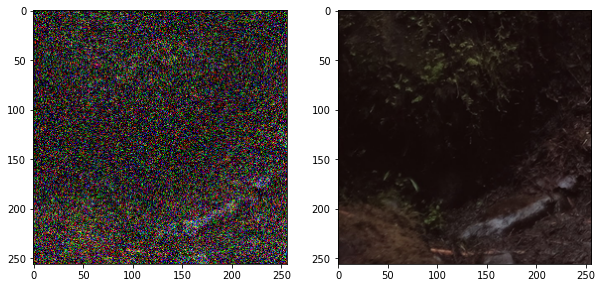

In [49]:
for x, y in noisy_dataloader:
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    axs[0].imshow(x[0].squeeze().permute(1,2,0))
    axs[1].imshow(y[0].squeeze().permute(1,2,0))
    break

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Models

In [ ]:
class ContentMetric(nn.Module):

    def __init__(self):
        super(ContentMetric, self).__init__()
        vgg19 = models.vgg19(pretrained = True).eval()
        # Extract the thirty-sixth layer output in the VGG19 model as the content loss.
        self.feature_extractor = nn.Sequential(*list(vgg19.features.children())[:36])

        for parameters in self.feature_extractor.parameters():
            parameters.requires_grad = False

        self.register_buffer("mean", torch.Tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std", torch.Tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, hr: torch.Tensor, sr: torch.Tensor):
        sr = sr.sub(self.mean).div(self.std)
        hr = hr.sub(self.mean).div(self.std)

        loss = F.l1_loss(self.feature_extractor(sr), self.feature_extractor(hr))

        return loss

In [ ]:
class ConvResBlock(nn.Module):
    """
    This is an implementation of a Residual Convolution Block from the article:
        https://arxiv.org/pdf/1609.04802.pdf
    """

    def __init__(
            self,
            channels: int = 64
    ):
        """
        :param channels: int
            How many channels should be in convolutional blocks
        """
        self.channels = channels
        super(ConvResBlock, self).__init__()

        self.conv_res_block = nn.Sequential(
            nn.Conv2d(
                in_channels = self.channels,
                out_channels = self.channels,
                kernel_size = 3,
                stride = 1,
                padding = 1
            ),
            nn.BatchNorm2d(self.channels),
            nn.PReLU(),
            nn.Conv2d(
                in_channels = self.channels,
                out_channels = self.channels,
                kernel_size = 3,
                stride = 1,
                padding = 1,
                bias = False
            ),
            nn.BatchNorm2d(self.channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of Residual Convolution Block
        :param x: torch.Tensor
            Input tensor
        :return: torch.Tensor
            Output tensor
        """
        initial_state = x
        out = self.conv_res_block(x)
        out = torch.add(out, initial_state)
        return out


class Generator(nn.Module):
    """
    Generator implementation of SRGAN from the article:
        https://arxiv.org/pdf/1609.04802.pdf
    """

    def __init__(
            self,
            input_channels: int = 3,
            out_channels: int = 64,
            input_kernel_size: int = 9,
            input_stride: int = 1,
            num_of_res_layers: int = 5
    ):
        super(Generator, self).__init__()

        self.input_channels = input_channels
        self.out_channels = out_channels
        self.input_kernel = input_kernel_size
        self.input_stride = input_stride
        self.first_conv_padding = int(np.ceil((self.input_kernel - self.input_stride) / 2))

        self.conv_1 = nn.Sequential(
            nn.Conv2d(
                in_channels = self.input_channels,
                out_channels = self.out_channels,
                kernel_size = self.input_kernel,
                stride = self.input_stride,
                padding = self.first_conv_padding
            ),
            nn.PReLU()
        )

        residual_block = []
        for i in range(num_of_res_layers):
            residual_block.append(ConvResBlock(self.out_channels))
        self.residual_block = nn.Sequential(*residual_block)

        self.conv_2 = nn.Sequential(
            nn.Conv2d(
                in_channels = self.out_channels,
                out_channels = self.out_channels,
                kernel_size = 3,
                stride = 1,
                padding = 1
            ),
            nn.BatchNorm2d(self.out_channels)
        )
        self.conv_3 = nn.Sequential(
            nn.Conv2d(
                in_channels = self.out_channels,
                out_channels = 256,
                kernel_size = 3,
                stride = 1,
                padding = 1
            ),
            nn.PixelShuffle(2),
            nn.PReLU(),
            nn.Conv2d(
                in_channels = self.out_channels,
                out_channels = 256,
                kernel_size = 3,
                stride = 1,
                padding = 1
            ),
            nn.PixelShuffle(2),
            nn.PReLU(),
        )

        self.conv_4 = nn.Conv2d(
            in_channels = self.out_channels,
            out_channels = 3,
            kernel_size = self.input_kernel,
            stride = self.input_stride,
            padding = self.first_conv_padding
        )

        self._initialize_weights()

    def _initialize_weights(self) -> None:
        """
        Weights initialization.
        For convolutional blocks there is "He initialization".
        :return:
            None
        """
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of Generator
        :param x: torch.tensor
            Input Tensor
        :return: torch.Tensor
            Output tensor
        """
        output_1 = self.conv_1(x)
        output_2 = self.residual_block(output_1)
        output = self.conv_2(output_2)
        output = torch.add(output, output_1)
        output = self.conv_3(output)
        output = self.conv_4(output)

        return output

"""
Discriminator's block of the model
"""

class convBlockDiscriminator(nn.Module):
    '''
    Block in the discriminator with different stride and in/out channels.
    '''
    def __init__(self,
               stride_size: int = 1,
               in_channels_size: int = 64,
               out_channels_size: int = 64
               ):
        super(convBlockDiscriminator, self).__init__()

        self.conv_block = nn.Sequential(nn.Conv2d(kernel_size=3, in_channels=in_channels_size, out_channels=out_channels_size, stride=stride_size),
                                        nn.BatchNorm2d(out_channels_size), 
                                        nn.LeakyReLU(inplace=True)
                                        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv_block(x)


class Discriminator(nn.Module):
    """
    Discriminator implementation of SRGAN from the article:
        https://arxiv.org/pdf/1609.04802.pdf
    """
    def __init__(self,
               in_channels_size: int = 3,
               out_channels_size: int = 64,
               layer_size: int = 1000
               ):
    

        super(Discriminator, self).__init__()


        self.conv_start_block = nn.Sequential(nn.Conv2d(kernel_size=3,
                                                        in_channels=in_channels_size,
                                                        out_channels=out_channels_size,
                                                        stride=1),
                                              nn.LeakyReLU(inplace=True))

        self.conv_blocks = nn.ModuleList()

        self.conv_block_1 = convBlockDiscriminator(2, 64, 128)
        self.conv_block_2 = convBlockDiscriminator(1, 128, 128)
        self.conv_block_3 = convBlockDiscriminator(2, 128, 256)
        self.conv_block_4 = convBlockDiscriminator(1, 256, 256)
        self.conv_block_5 = convBlockDiscriminator(2, 256, 512)
        self.conv_block_6 = convBlockDiscriminator(1, 512, 512)
        self.conv_block_7 = convBlockDiscriminator(2, 512, 512)

        self.linear_block = nn.Sequential(nn.Linear(512*13*13, layer_size),
                                          nn.LeakyReLU(inplace=True),
                                          nn.Linear(layer_size, 1))


        self._initialize_weights()
    def _initialize_weights(self) -> None:
        """
        Weights initialization.
        For convolutional blocks there is "He initialization".
        :return:
            None
        """
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Forward pass of Discriminator
        :param x: torch.tensor
            Input Tensor
        :return: torch.Tensor
            Output tensor
        '''
        out = self.conv_start_block(x)

        out = self.conv_block_1(out)
        out = self.conv_block_2(out)
        out = self.conv_block_3(out)
        out = self.conv_block_4(out)
        out = self.conv_block_5(out)
        out = self.conv_block_6(out)
        out = self.conv_block_7(out)

        out = out.flatten(start_dim=1)


        out = self.linear_block(out) 

        return F.sigmoid(out)

In [ ]:
generator = Generator(num_of_res_layers=7).to(device)
# discriminator = Discriminator().to(device)

generator_loss = nn.MSELoss()
# discriminator_loss = nn.BCEWithLogitsLoss()

generator_optimizer = torch.optim.Adam(generator.parameters(),
                                  lr=1e-4)
# discriminator_optimizer = torch.optim.Adam(discriminator.parameters(),
#                                   lr=1e-4)

In [ ]:
def show_picture(dataload, generator, device):
    generator.eval()
    i = 0
    for x, y in dataload:
        with torch.no_grad():
            i += 1
            pred = generator(x.to(device))
            loss = F.mse_loss(pred, y.to(device))
            fig, axs = plt.subplots(1, 2, figsize=(10, 10))
            axs[0].imshow(pred[0].squeeze().permute(1,2,0).detach().cpu().numpy())
            axs[0].set_title('loss = %s'%loss)
            axs[1].imshow(y[0].squeeze().permute(1,2,0).detach().cpu().numpy())
        if i==2:
            break

In [ ]:
from IPython.display import clear_output
from tqdm.notebook import tqdm
def train(
    train_loader,
    valid_loader,
    generator,
    # discriminator,
    gen_loss,
    # discr_loss,
    gen_optim,
    # discr_optim,
    device,
    epochs: int
):
    content_loss = ContentMetric().to(device)
    history_general = list()
    best_params_generator = 0 
    # history_loss_hr = list()
    # history_loss_sr = list()
    history_mse = list()
    # history_discr_loss = list()
    # discriminator.train()
    # scheduler_dicr = lr_scheduler.StepLR(discr_optim, step_size=10, gamma=0.1)
    scheduler_gener = lr_scheduler.StepLR(gen_optim, step_size=10, gamma=0.1)
    i=0
    for epoch in range(epochs):
        print("epochs =  ", (i+1))
        i += 1
        generator.train()
        for lr, hr in tqdm(train_loader):
           
            lr = lr.to(device)
            hr = hr.to(device)

            # real_label = torch.full([lr.size(0), 1], 1.0, dtype = lr.dtype, device = device)
            # fake_label = torch.full([lr.size(0), 1], 0.0, dtype = lr.dtype, device = device)

            sr = generator(lr)

            # for p in discriminator.parameters():
            #     p.requires_grad = True

            # discr_optim.zero_grad()

            # hr_output = discriminator(hr)
            # discriminator_hr_loss = discriminator_loss(hr_output, real_label)
            # history_loss_hr.append(discriminator_hr_loss.item())
            # discriminator_hr_loss.backward()

            # sr_output = discriminator(sr.detach())
            # discriminator_sr_loss = discriminator_loss(sr_output, fake_label)
            # history_loss_sr.append(discriminator_sr_loss.item())
            # # discriminator_sr_loss.backward()
            # total_dicriminator_loss = (discriminator_hr_loss 
            #                            + discriminator_sr_loss)
            # total_dicriminator_loss.backward()

            # discr_optim.step()

            # total_dicriminator_loss = (discriminator_hr_loss 
            #                            + discriminator_sr_loss)

            # for p in discriminator.parameters():
            #     p.requires_grad = False

            gen_optim.zero_grad()

            # output = discriminator(sr)
            pixel_loss =  gen_loss(sr, hr.detach())
            c_loss =  content_loss(sr, hr.detach())
            # adversarial_loss = 0.001 * discriminator_loss(output, real_label)
            # generator_loss_tr = generator_loss(sr, hr)
            history_mse.append(pixel_loss.item())
            g_loss = pixel_loss + c_loss #+ adversarial_loss
            history_general.append(g_loss.item())
            # history_discr_loss.append(total_dicriminator_loss)
            # Gradient zoom
            g_loss.backward()
            # Update generator parameters
            gen_optim.step()
            
        # scheduler_dicr.step()
        scheduler_gener.step()
        clear_output(True)
        fig, axs = plt.subplots(1, 3, figsize=(10, 6), dpi=100)
        # axs[0].plot(history_discr_loss)
        # axs[0].set_title('Discriminator loss')
        # axs[1].plot(history_loss_sr)
        # axs[1].set_title('Discriminator with fake labels')
        axs[1].plot(history_mse)
        axs[1].set_title('MSE loss generator')
        axs[1].plot(history_general)
        axs[1].set_title('General loss generator')
        plt.show()
        time.sleep(5)
        clear_output(True)
        j = 0
        val_losses = [1]
        generator.eval()
        for x, y in valid_loader:
            with torch.no_grad():
                j += 1
                pred = generator(x.to(device))
                loss = F.mse_loss(pred, y.to(device))
                fig, axs = plt.subplots(1, 2, figsize=(4, 8))
                axs[0].imshow(pred[0].squeeze().permute(1,2,0).detach().cpu().numpy())
                axs[0].set_title('loss = %s'%loss)
                axs[1].imshow(y[0].squeeze().permute(1,2,0).detach().cpu().numpy())
                plt.show()
                print(loss.item())
                
                if loss.item() < val_losses[-1]:
                  torch.save(generator.state_dict(), '/content/drive/MyDrive/models/srgan/generator_v5.pt')
                  # torch.save(discriminator.state_dict(), '/content/drive/MyDrive/models/srgan/discriminator.pt')
                val_losses.append(loss.item())
                
            if j==1:
                break
        time.sleep(2)
        if epoch % 5 == 0:
          df = pd.DataFrame({#'discrimanator_loss': history_discr_loss, 
                             'generator_mse_loss': history_mse,
                             'general_loss': history_general})
          df.to_csv('/content/drive/MyDrive/data/results/srgan_losses_5.csv')

    return history_general, history_mse, val_losses #history_loss_hr, history_loss_sr, history_discr_loss, history_mse

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


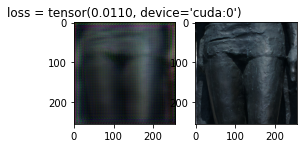

0.01098441518843174


In [ ]:
h_gen, h_mse, val_losses = train(dataloader, dataloader_valid, generator,
                             generator_loss,
                           generator_optimizer,  device, 20)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
val_losses

[1, 0.01098441518843174]

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(h_gen))), y=h_gen, name='general_loss'))
fig.add_trace(go.Scatter(x=list(range(len(h_gen))), y=h_mse, name='mse_loss'))
fig.add_trace(go.Scatter(x=list(range(len(h_gen))), y=val_losses, name='val_loss'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


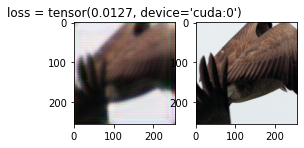

0.012690158560872078
epochs =   32


  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
h_l_h, h_l_s, h_discr, h_mse = train(dataloader, dataloader_valid, generator,
                            discriminator, generator_loss, discriminator_loss,
                           generator_optimizer, discriminator_optimizer, device, 40)

### Denoising

In [7]:
class MRU_block(nn.Module):

    def __init__(
            self,
            output_channels: int = 64,
            first_dilation: int = 1,
            second_dilation: int = 2
    ):
        super(MRU_block, self).__init__()

        self.layer = nn.Sequential(
            nn.Conv2d(
                in_channels = output_channels,
                out_channels = output_channels,
                kernel_size = 3,
                stride = 1,
                padding = first_dilation,
                dilation = first_dilation
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels = output_channels,
                out_channels = output_channels,
                kernel_size = 3,
                stride = 1,
                padding = second_dilation,
                dilation = second_dilation
            ),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output = self.layer(x)
        return output


class FeatureAttention(nn.Module):

    def __init__(
            self,
            input_channels: int = 64,
            reduction_level: int = 4
    ):
        super(FeatureAttention, self).__init__()

        self.layer = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(
                in_channels = input_channels,
                out_channels = input_channels // reduction_level,
                kernel_size = 1,
                stride = 1,
                padding = 0
            ),
            nn.Conv2d(
                in_channels = input_channels // reduction_level,
                out_channels = input_channels,
                kernel_size = 1,
                stride = 1,
                padding = 0
            ),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.layer(x)
        output = x + x1
        return output


class EAM(nn.Module):

    def __init__(
            self,
            output_channels: int = 64,
            first_branch_dilations: list = [1, 2],
            second_branch_dilations: list = [3, 4],
            downsampling: int = 16
    ):
        super(EAM, self).__init__()

        self.first_branch = MRU_block(
            output_channels = output_channels,
            first_dilation = first_branch_dilations[0],
            second_dilation = first_branch_dilations[1]
        )

        self.second_branch = MRU_block(
            output_channels = output_channels,
            first_dilation = second_branch_dilations[0],
            second_dilation = second_branch_dilations[1]
        )

        self.conc_conv = nn.Sequential(
            nn.Conv2d(
                in_channels = output_channels * 2,
                out_channels = output_channels,
                kernel_size = 3,
                stride = 1,
                padding = 1
            ),
            nn.ReLU()
        )

        self.second_block = nn.Sequential(
            nn.Conv2d(
                in_channels = output_channels,
                out_channels = output_channels,
                kernel_size = 3,
                stride = 1,
                padding = 1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels = output_channels,
                out_channels = output_channels,
                kernel_size = 3,
                stride = 1,
                padding = 1
            ),
            nn.ReLU()
        )

        self.third_block = nn.Sequential(
            nn.Conv2d(
                in_channels = output_channels,
                out_channels = output_channels,
                kernel_size = 3,
                stride = 1,
                padding = 1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels = output_channels,
                out_channels = output_channels,
                kernel_size = 3,
                stride = 1,
                padding = 1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels = output_channels,
                out_channels = output_channels,
                kernel_size = 1,
                stride = 1,
                padding = 0
            ),
            nn.ReLU()
        )

        self.feature_attention = FeatureAttention(input_channels = output_channels)

        self.fourth_block = nn.Sequential(
            nn.Conv2d(
                in_channels = output_channels,
                out_channels = output_channels // downsampling,
                kernel_size = 1,
                stride = 1,
                padding = 0
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels = output_channels // downsampling,
                out_channels = output_channels,
                kernel_size = 1,
                stride = 1,
                padding = 0
            ),
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b_1 = self.first_branch(x)
        b_2 = self.second_branch(x)
        c = torch.cat([b_1, b_2], dim = 1)

        x1 = self.conc_conv(c)
        x1_1 = x1 + x

        x2 = self.second_block(x1)
        x2_1 = x2 + x1

        x3 = self.third_block(x2_1)
        x3_1 = x3 + x2

        x4 = self.feature_attention(x3_1)
        x4 = self.fourth_block(x4)
        x5 = x4 * x3

        output = x + x5

        return output


class RidNet(nn.Module):

    def __init__(self,
                 out_channels: int = 64,
                 n_res_block: int = 4,
                 first_branch_dilations: list = [1, 2],
                 second_branch_dilations: list = [3, 4],
                 downsampling: int = 16
                 ):
        super(RidNet, self).__init__()

        self.feature_extraction = nn.Sequential(
            nn.Conv2d(in_channels = 3,
                      out_channels = out_channels,
                      kernel_size = 3,
                      padding = 1
                      ),
            nn.ReLU()
        )

        residual_block = []
        for i in range(n_res_block):
            residual_block.append(EAM(
                output_channels = out_channels,
                first_branch_dilations = first_branch_dilations,
                second_branch_dilations = second_branch_dilations,
                downsampling = downsampling
            ))
        self.residual_block = nn.Sequential(*residual_block)

        self.last_conv = nn.Sequential(
            nn.Conv2d(
                in_channels = out_channels,
                out_channels = 3,
                kernel_size = 3,
                stride = 1,
                padding = 1
            )
        )

        self._initialize_weights()

    def _initialize_weights(self) -> None:
        """
        Weights initialization.
        For convolutional blocks there is "He initialization".
        :return:
            None
        """
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x1 = self.feature_extraction(x)
        x2 = self.residual_block(x1)
        x3 = x2 + x1
        x4 = self.last_conv(x2)
        output = x + x4
        return output


In [8]:
denoiser = RidNet().to(device)
denoiser_loss = nn.L1Loss()
denoiser_optimizer = torch.optim.Adam(denoiser.parameters(),
                                  lr=1e-4)

In [11]:
from IPython.display import clear_output
from tqdm.notebook import tqdm
def train_denoiser(
    train_loader,
    valid_loader,
    denoiser,
    denoiser_loss,
    denoiser_optim,
    device,
    epochs: int
):
    
    train_history_loss = list()
    i=0
    for epoch in range(epochs):
        print("epochs =  ", (i+1))
        i += 1
        denoiser.train()
        for X, y in tqdm(train_loader):
           
            X = X.to(device)
            y = y.to(device)

            output = denoiser(X)

            denoiser_optim.zero_grad()

            train_loss =  denoiser_loss(output.to(device), y)
            train_history_loss.append(train_loss.item())
            train_loss.backward()
            # Update generator parameters
            denoiser_optim.step()
            
        clear_output(True)
        fig, axs = plt.subplots(1, 2, figsize=(10, 6), dpi=100)
        
        axs[0].plot(train_history_loss)
        axs[0].set_title('L1 loss')
        plt.show()
        time.sleep(5)
        clear_output(True)
        j = 0
        val_losses = [1]
        denoiser.eval()
        for x, y in valid_loader:
            with torch.no_grad():
                j += 1
                pred = denoiser(x.to(device))
                loss = denoiser_loss(pred, y.to(device))
                fig, axs = plt.subplots(1, 2, figsize=(4, 8))
                axs[0].imshow(pred[0].squeeze().permute(1,2,0).detach().cpu().numpy())
                axs[0].set_title('loss = %s'%loss)
                axs[1].imshow(y[0].squeeze().permute(1,2,0).detach().cpu().numpy())
                plt.show()
                print(loss.item())
                
                if loss.item() < val_losses[-1]:
                  torch.save(denoiser_loss.state_dict(), '/content/drive/MyDrive/models/srgan/denoiser_v1.pt')
                val_losses.append(loss.item())
                
            if j==1:
                break
        time.sleep(2)

    return train_history_loss, val_losses

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


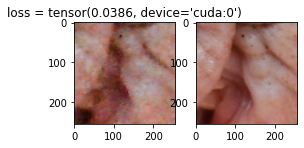

0.0386427566409111


In [12]:
train_losses, val_losses = train_denoiser(noisy_dataloader, noisy_dataloader_valid, denoiser,
                             denoiser_loss,
                           denoiser_optimizer, device, 40)